### This notebook process the initial dataset, in order to extract usefull information from it. 

In this dataset there are trajectories from taxis in San Francisco. All the trajectories provide <b>Latitude</b> and <b>Longitude</b> infromation, as well as <b>Timestamp</b>. All the trajectories have been traced in May 2008.

In [1]:
# measure execution time
%load_ext autotime

time: 0 ns (started: 2023-06-01 14:19:48 +03:00)


In [2]:
# import libraries
import os
import json
import random
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import plotly_express as px
import matplotlib.pyplot as plt
import tqdm
from tqdm.notebook import tqdm_notebook
from datetime import datetime, timedelta

%matplotlib inline

time: 12.9 s (started: 2023-06-01 14:19:48 +03:00)


### Phase 1: Preprocess the dataset
In this step, the following commands are executed:
- Add Taxi ID on the data
- Gather all the data in one txt file
- Convert time information to timestamp
- Split trajectories, based in the time field
- Delete unnecessary columns

In [ ]:
# define the path in which data are stored
path = 'C:/Users/SK/Desktop/Diploma_Thesis/Datasets/San-Francisco-Yellow-Cabs/Data'

counter = 0 # Taxi ID starts from 0

# create an empty dataframe, in which all the data will be saved
all_data = pd.DataFrame(columns=['Taxi ID','Latitude','Longitude','Occupied','Date Time'])

for filename in os.listdir(path):
    
    # read each file in the Data folder
    temp = pd.read_csv(path+'/'+filename,names=['Latitude','Longitude','Occupied','Date Time'],sep=' ')
    
    # assign Taxi ID number to each file
    temp.insert(1,'Taxi ID',counter)
    
    # add the data in this file in the 'all_data' dataframe
    all_data = pd.concat([all_data, temp],ignore_index = True)
    
    counter += 1 # Increase Taxi ID number by 1    

In [ ]:
# save data to txt file
all_data.to_csv('C:/Users/SK/Desktop/Diploma_Thesis/Datasets/San-Francisco-Yellow-Cabs/Files/all_data.txt',index=False)

#### Change datetime field to timestamp

In [ ]:
all_data['Date Time'] = pd.to_datetime(all_data['Date Time'],origin='unix',unit='s')

In [ ]:
# choose the data of one week
all_data = all_data[(all_data['Date Time'] >= "2008-05-18 00:00:00") & (all_data['Date Time'] < "2008-05-25 00:00:00")]

#### Sort the data based in Taxi ID and timestamp information

In [ ]:
all_data = all_data.sort_values(['Taxi ID','Date Time'])
all_data = all_data.reset_index(drop=True)

#### Delete the 'Occupied' column
This column denotes whether or not the taxi was occupied by a passenger, at the time of GPS recording. So, this information is not usefull for our research.

In [ ]:
all_data.drop('Occupied',axis=1,inplace=True)

#### Split the trajectories based in time field and FIle ID

Split each trajectory in the same Taxi ID based in the timestamp field.

Here, <b>n_sec</b> variable denotes the maximum number of seconds that consecutive GPS traces in the same trajectory should have.

In [ ]:
all_data.insert(1,'Traj ID',-1)

In [ ]:
''' 
Each Taxi ID contains GPS data of one trajectory

If the time gap between two GPS points is lower than n_sec seconds, (condition 1)
and these GPS points belong to the same Taxi ID  (condition 2)
then asign the same Traj ID number. (result)

If the time gap between two GPS points is higher than n_sec seconds, (condition 1)
and these GPS points belong to the same Taxi ID  (condition 2)
then asign different Traj ID number to each of these GPS points. (result)

If the GPS points belong to the same Taxi ID  (condition 2)
then asign different Traj ID number to each of these GPS points. (result)

'''

# max number of seconds between GPS records of each traectory
n_sec = 90
traj_id = 0

for i in range(all_data.shape[0] -1):
    
    if (all_data['Taxi ID'][i+1] == all_data['Taxi ID'][i]): # belong to the same File ID
        
        if (((all_data['Date Time'][i+1])-(all_data['Date Time'][i])).total_seconds() <= n_sec): # time interval less-equal than n_sec
            all_data.at[i,'Traj ID'] = traj_id
            all_data.at[i+1,'Traj ID'] = traj_id
            
        else: # time interval higher than n_sec
            all_data.at[i,'Traj ID'] = traj_id
            traj_id +=1
            all_data.at[i+1,'Traj ID'] = traj_id
    
    else: # not belong to the same File ID
        all_data.at[i,'Traj ID'] = traj_id
        traj_id  = 0
        all_data.at[i+1,'Traj ID'] = traj_id

#### Delete trajectories, which contain only one OSM Way ID

In [ ]:
uniques = all_data.loc[:, ['Taxi ID', 'Traj ID']].drop_duplicates(keep=False).index
all_data.drop(uniques,axis=0,inplace=True)
all_data.reset_index(drop=True,inplace=True)

#### Find min and max date in this dataset

In [ ]:
print("Min date is: "+str(all_data['Date Time'].min()))
print("Max date is: "+str(all_data['Date Time'].max()))

In [ ]:
# save data to txt file (with information of splitted trajectories)
all_data.to_csv('C:/Users/SK/Desktop/Diploma_Thesis/Datasets/San-Francisco-Yellow-Cabs/splitted_trajectories90.txt',index=False)

#### Begin Map Matching

Map matching done using Valhalla Meili API. Given each trajectory to the API as input, the response contains information of the exact path that each trajectory followed. The paths are in the form of OSM Way IDs. 

Sources:

-  <b>Installation using Docker: </b>https://ikespand.github.io/posts/meili/
-  <b>Paper about Valhalla: </b>https://link.springer.com/article/10.1007/s42979-022-01340-5#Tab5
-  <b>APIs documentation: </b>https://valhalla.github.io/valhalla/api/map-matching/api-reference/#matched-point-items  

In [ ]:
# pass lat and lot pairs to Valhalla API
df_for_meili = all_data[['Latitude','Longitude']]
df_for_meili = df_for_meili.rename(columns={"Latitude": "lat", "Longitude": "lon"})

Create a new dataframe under the name "visited_segments", in which information about each trajectory will be contained. The columns of this new dataframe are:
-  <b>File ID: </b>The folder that contains information of this trajecotry.
-  <b>Traj ID: </b>The ID of the trajectory in this folder.
-  <b>OSM Way ID: </b>The way ID number of the edge that trajectory visited.
-  <b>Start Time: </b>Expected time that trajecotry enter the specific edge.
-  <b>End Time: </b>Expected time that trajecotry left the specific edge.

In [ ]:
visited_segments = pd.DataFrame(columns=['Taxi ID','Traj ID','OSM Way ID','Start Time','End Time'])

for taxi_id in all_data['Taxi ID'].unique():
    for traj_id in all_data[all_data['Taxi ID'] == taxi_id]['Traj ID'].unique():

            # get the batch of data that we send to the request
            indexes = all_data[(all_data['Taxi ID']==taxi_id) & (all_data['Traj ID'] == traj_id)].index
            
            # input to API
            passed_data = df_for_meili.iloc[indexes]

            # Preparing the request to Valhalla's Meili
            meili_coordinates = passed_data.to_json(orient='records')
            meili_head = '{"shape":'
            meili_tail = ""","search_radius": 250, "sigma_z": 10, "beta": 10,"shape_match":"map_snap", "costing":"auto",
                            "filters":{"attributes":["edge.way_id"],"action":"include"},
                            "format":"osrm"}"""

            # this is the request
            meili_request_body = meili_head + meili_coordinates + meili_tail

            # the URL of the local valhalla server
            url = "http://localhost:8002/trace_attributes"

            # providing headers to the request
            headers = {'Content-type': 'application/json'}

            # we need to send the JSON as a string
            data = str(meili_request_body)

            # sending a request
            r = requests.post(url, data=data, headers=headers)

            if r.status_code == 200: # response from Valhalla API was successful

                # Parsing the JSON response
                response_text = json.loads(r.text)

                # find the time interval (in sec) that the trajectory needs to be completed [last timestamp - first timestamp]
                interval = (all_data.iloc[indexes].iloc[-1]['Date Time'] - all_data.iloc[indexes].iloc[0]['Date Time']).total_seconds()

                # compute the expected duration that the moving object is in each edge (duration is equal for each edge that the trajectory visits)
                duration  = interval/len(response_text['edges'])

                # make a temporary dataframe
                temp = pd.DataFrame(columns=['Taxi ID','Traj ID','OSM Way ID','Start Time','End Time'])

                # make the final dataframe with the help of a temporary dataframe
                for i in range(len(response_text['edges'])):

                    # complete the fields of temp dataframe
                    temp.at[i,'Taxi ID'] = taxi_id
                    temp.at[i,'Traj ID'] = traj_id
                    temp.at[i,'OSM Way ID'] = response_text['edges'][i]['way_id']

                    if i == 0:
                        temp.at[i,'Start Time'] = all_data.iloc[indexes].iloc[0]['Date Time']
                    else:
                        temp.at[i,'Start Time'] = temp.at[i-1,'End Time']

                    temp.at[i,'End Time'] = temp.at[i,'Start Time'] + timedelta(seconds=duration)

                # concatenate the two dataframes
                visited_segments = pd.concat([visited_segments,temp],ignore_index=True)

#### Delete trajectories, which contain only one OSM Way ID

In [ ]:
uniques = visited_segments.loc[:, ['Taxi ID', 'Traj ID']].drop_duplicates(keep=False).index
visited_segments.drop(uniques,axis=0,inplace=True)
visited_segments.reset_index(drop=True,inplace=True)
visited_segments = visited_segments.sort_values(['Taxi ID','Traj ID','Start Time']).reset_index(drop=True)

In [ ]:
# save the new dataframe to separate txt file
visited_segments.to_csv('C:/Users/SK/Desktop/Diploma_Thesis/Datasets/San-Francisco-Yellow-Cabs/Files/visited_segments.txt',index=False)

### Phase 2: Make the time series dataset

In [3]:
# read and sort the data. Also, convert timestamps to datetime data type
visited_segments = pd.read_csv('C:/Users/SK/Desktop/Diploma_Thesis/Datasets/San-Francisco-Yellow-Cabs/Files/visited_segments.txt')
visited_segments['Start Time'] = pd.to_datetime(visited_segments['Start Time'],format='%Y-%m-%d %H:%M:%S.%f')
visited_segments['End Time'] = pd.to_datetime(visited_segments['End Time'],format='%Y-%m-%d %H:%M:%S.%f')

time: 2min 6s (started: 2023-06-01 14:20:01 +03:00)


#### Step 1: Create the time information of the dataset

In [4]:
# find max and min timestamp in the dataset
min_timestamp = visited_segments['Start Time'].min()
print("Min timestamp value in the dataframe is: ",min_timestamp)

max_timestamp = visited_segments['End Time'].max()
print("Max timestamp value in the dataframe is: ",max_timestamp)


# calculate total seconds between those max and min values
total_sec = (max_timestamp-min_timestamp).total_seconds()
print("\nTotal duration in sec in this dataframe is: ",total_sec)

Min timestamp value in the dataframe is:  2008-05-18 00:00:00
Max timestamp value in the dataframe is:  2008-05-24 23:59:59.000130

Total duration in sec in this dataframe is:  604799.00013
time: 203 ms (started: 2023-06-01 14:22:07 +03:00)


###### Since we have data of one week, we will create time intervals  of half hour

In [8]:
# this list contains the time information of our time-series data
time_info = []

i =0
while(True):
    if i == 0:
        time_info.append(min_timestamp)
    else:
        time_info.append(time_info[i-1] + timedelta(seconds=1800))
    
    if (time_info[i]>=max_timestamp):
        break
    
    i+=1 

# create pairs of consequtive values of the list time_info
time_intervals = list(zip(*[time_info[i:] for i in range(2)])) 

time: 16 ms (started: 2023-06-01 14:24:29 +03:00)


#### Step 2: Generate random unique paths of random lengths
These paths can be of any length. The number of consecutive edges contained in the path define it's length.

In [9]:
paths = pd.DataFrame(columns=['Taxi ID','Traj ID','Path','Length']) # empty dataframe, in which all the paths will be saved

length_options = [2,3,4,5,6,7,8,9,10,11,12,13,14,15] # define the length options

check = [] # this list is used, in order to be sure that paths created are unique

indexes = np.arange(visited_segments.shape[0]-max(length_options)+1) # legal indexes in which algorithm can search for paths

i = 0
n = 1000 # number of paths to be created

while (paths.shape[0] < n):
    p = [] # this list will save the path created
    selected_index = random.choice(indexes) # select randomly an index   
    selected_length = random.choice(length_options) # the length of the new path to be created

    # check if path is within the same trajectory
    if ((visited_segments.at[selected_index,'Taxi ID'] == visited_segments.at[selected_index+(selected_length-1),'Taxi ID']) & 
        (visited_segments.at[selected_index,'Traj ID'] == visited_segments.at[selected_index+(selected_length-1),'Traj ID'])):
        
        # iterate to the visited_segments dataframe and extract the consequtive 
        # [selected_index...index+selected_length] OSM Way IDs
        for y in range(selected_length): 
            p.append(int(visited_segments.at[selected_index+y,'OSM Way ID']))
    
        # if path is unique, then add it to paths dataframe
        if p not in check: 
            check.append(p)
            paths.at[i,'Taxi ID'] = visited_segments.at[selected_index,'Taxi ID']
            paths.at[i,'Traj ID'] = visited_segments.at[selected_index,'Traj ID']
            paths.at[i,'Path'] = p # add the new path to the dataframe
            paths.at[i,'Length'] = selected_length
            i += 1
        else:
            continue      

time: 1.09 s (started: 2023-06-01 14:24:36 +03:00)


#### Step 3a: Create the SPQ function

This is the main function that will be used for the construction of the time series dataset.
The SPQ (Strict Path Query) function, returns all the trajectories [the trajectories are unique (Taxi_ID,Traj_ID) pairs] that passes through given path of edges at a given time interval [time_enter,time_leave].

Parameters:
- <b>path: </b> The path that the tajectories should EXACTLY follow (edge by edge). This path can be of any length greater or equal to 2 edges.

- <b>time_enter: </b>The time, in which the trajectory should enter the first edge of the path given as input.
- <b>time_leave: </b>The time, in which the trajectory should leave the last edge of the path given as input.

In [10]:
def SPQ(path,time_enter,time_leave):
    
    # length of the path given to the function
    path_length = len(path)
    
    # this list will save temporarily the trajectories that match the SPQ condition
    trajectories = []
    
    # extract only the data that match the time interval given as input
    #examined_data = visited_segments[(visited_segments['Start Time'] >= time_enter) & (visited_segments['End Time'] <= time_leave)].reset_index(drop=True)

    # find all the indexes, in which the first edge in the path is located
    needed_indexes = examined_data[examined_data['OSM Way ID'] == path[0]].index

    # iterate through all indexes (note the Taxi_ID and Traj_ID numbers)
    for index in needed_indexes:

        traj_id = examined_data.at[index,'Traj ID']
        taxi_id = examined_data.at[index,'Taxi ID']
        inter = 1
        
        # decide if the row in the next index matches the criteria (same Taxi_ID, same Traj_ID, the path required)
        for i in range(1,path_length):
            try:
                if (not ((examined_data['OSM Way ID'].iloc[index+i] == path[i]) 
                         & (examined_data['Traj ID'].iloc[index+i] == traj_id) 
                        & (examined_data['Taxi ID'].iloc[index+i] == taxi_id))):

                    break

                inter += 1 # if the criteria matches, then increase inter counter by one

            except:
                pass # index out of bounds exception (do nothing)
            
        # if the criteria matches as many times as the length of the path, then we found one trajectory
        if (path_length == inter):
            trajectories.append((taxi_id,traj_id)) # add this trajectory to the trajectories list
    
    # return the number of trajectories that matches the criteria
    return (len([t for t in (set(tuple(i) for i in trajectories))]))

time: 0 ns (started: 2023-06-01 14:24:40 +03:00)


#### Step 3b: Create the same SPQ function using postgreSQL

In order to do this, we have loaded the visited_segments data into a table called "visited_segments". The SPQ function has been rewritten using PLpgsql language. In order to accelerate the execution of this function, we have defined B+ tree indexes on columns of the visited)_segments table.

In [25]:
'''
# open conncection with the database
import psycopg2

# Connection parameters
hostname = 'localhost'
database = 'San Francisco'
username = 'postgres'
password = 'sobadata2'

# Connect to the PostgreSQL database
connection = psycopg2.connect(
    host=hostname,
    database=database,
    user=username,
    password=password
)

cursor = connection.cursor()

# call plpgsql function
function_call = "SELECT spq(%s, %s, %s);"

# define the path
path = paths.at[9,'Path'] # Example path array

# define the time interval
time_ent = time_intervals[8][0]  # Example timestamp
time_leav = time_intervals[8][1]

# call the function with parameters
cursor.execute(function_call, (path, time_ent, time_leav))

# fetch the results
result = cursor.fetchone()

value = result[0]
print("Result:", value)

cursor.close()

SPQ(paths.at[9,'Path'],time_intervals[8][0],time_intervals[8][1])
connection.close()'''

'\n# open conncection with the database\nimport psycopg2\n\n# Connection parameters\nhostname = \'localhost\'\ndatabase = \'San Francisco\'\nusername = \'postgres\'\npassword = \'sobadata2\'\n\n# Connect to the PostgreSQL database\nconnection = psycopg2.connect(\n    host=hostname,\n    database=database,\n    user=username,\n    password=password\n)\n\ncursor = connection.cursor()\n\n# call plpgsql function\nfunction_call = "SELECT spq(%s, %s, %s);"\n\n# define the path\npath = paths.at[9,\'Path\'] # Example path array\n\n# define the time interval\ntime_ent = time_intervals[8][0]  # Example timestamp\ntime_leav = time_intervals[8][1]\n\n# call the function with parameters\ncursor.execute(function_call, (path, time_ent, time_leav))\n\n# fetch the results\nresult = cursor.fetchone()\n\nvalue = result[0]\nprint("Result:", value)\n\ncursor.close()\n\nSPQ(paths.at[9,\'Path\'],time_intervals[8][0],time_intervals[8][1])\nconnection.close()'

time: 15 ms (started: 2023-05-30 20:45:50 +03:00)


#### Compare the two methods, using plots. The comparation is based in time of execution.

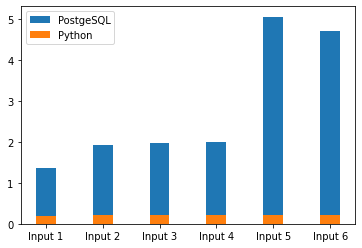

time: 18.5 s (started: 2023-05-30 20:47:19 +03:00)


In [27]:
import matplotlib.pyplot as plt
import time

# Connection parameters
hostname = 'localhost'
database = 'San Francisco'
username = 'postgres'
password = 'sobadata2'

# Connect to the PostgreSQL database
connection = psycopg2.connect(
    host=hostname,
    database=database,
    user=username,
    password=password
)

# Function to measure the execution time of a script
def measure_execution_time(script, input_data):
    start_time = time.time()
    # Run the script with the input data
    exec(script, globals(), {'input_data': input_data})
    end_time = time.time()
    execution_time = end_time - start_time
    return execution_time

# Define your scripts
script1 = """
cursor = connection.cursor()
function_call = "SELECT spq(%s, %s, %s);"
cursor.execute(function_call, (input_data[0], input_data[1], input_data[2]))
cursor.close()
"""

script2 = """
SPQ(input_data[0], input_data[1], input_data[2])
"""

# Define the input data
inputs = ['Input 1', 'Input 2', 'Input 3','Input 4','Input 5','Input 6']  # List of input names
input_data1 = [paths.at[0,'Path'],str(time_intervals[0][0]),str(time_intervals[0][1])]
input_data2 = [paths.at[1,'Path'],str(time_intervals[4][0]),str(time_intervals[4][1])]
input_data3 = [paths.at[4,'Path'],str(time_intervals[12][0]),str(time_intervals[12][1])]
input_data4 = [paths.at[8,'Path'],str(time_intervals[12][0]),str(time_intervals[12][1])]
input_data5 = [paths.at[6,'Path'],str(time_intervals[18][0]),str(time_intervals[18][1])]
input_data6 = [paths.at[2,'Path'],str(time_intervals[56][0]),str(time_intervals[56][1])]

# Measure the execution times for each input and script
execution_times1 = []
execution_times2 = []

for input_name in inputs:
    input_data = globals()[f'input_data{input_name[-1]}']
    
    execution_time1 = measure_execution_time(script1, input_data)
    execution_times1.append(execution_time1)
    
    execution_time2 = measure_execution_time(script2, input_data)
    execution_times2.append(execution_time2)

# Create a grouped bar chart to compare the execution times
script_names = ['PostgeSQL', 'Python']
bar_width = 0.35
index = range(len(inputs))

plt.bar(index, execution_times1, bar_width, label='PostgeSQL')
plt.bar(index, execution_times2, bar_width, label='Python')
plt.xticks(index, inputs)
plt.legend()
plt.show()

connection.close() # close connection

#### Step 4: Fill the time series dataframe

In [11]:
# create an empty dataframe
time_series = pd.DataFrame(columns=time_intervals)
time_series.insert(0,'Taxi ID',0)
time_series.insert(1,'Traj ID',0)
time_series.insert(2,'Path',0)
time_series.insert(3,'Length',0)
time_series['Path'] = paths['Path']
time_series['Length'] = paths['Length']
time_series['Taxi ID'] = paths['Taxi ID']
time_series['Traj ID'] = paths['Traj ID']

time: 31 ms (started: 2023-06-01 14:24:48 +03:00)


In [ ]:
# fill the dataframe column by column
for time in time_intervals:
    i = 0
    examined_data = visited_segments[(visited_segments['Start Time'] >= time[0]) & (visited_segments['End Time'] <= time[1])].reset_index(drop=True)
    for path in paths['Path'].to_list():
        time_series.at[i,time] = SPQ(path,time[0],time[1])
        i += 1

In [ ]:
# print the dataframe
time_series

### Phase 3: Visualization

In [ ]:
# count the number of paths grouped by length attribute
plt.figure(figsize=(12,5))
sns.countplot(time_series,x='Length')
plt.xlabel('Length inputs')
plt.ylabel('Count')
plt.title('Distribution of path lenghts in the dataset')
plt.show()

#### Plot some time series

In [ ]:
import plotly
import plotly.express as px
import plotly.graph_objects as go

trace1 = go.Scatter(
 x = time_info,
 y = time_series.iloc[0,4:],
 mode = 'lines',
 name = 'Path of Length: '+str(time_series.at[0,'Length'])
)

trace2 = go.Scatter(
 x = time_info,
 y = time_series.iloc[2,4:],
 mode = 'lines',
 name = 'Path of Length: '+str(time_series.at[2,'Length'])
)

trace3 = go.Scatter(
 x = time_info,
 y = time_series.iloc[3,4:],
 mode = 'lines',
 name = 'Path - Length: '+str(time_series.at[3,'Length'])
)

trace4 = go.Scatter(
 x = time_info,
 y = time_series.iloc[4,4:],
 mode = 'lines',
 name = 'Path of Length: '+str(time_series.at[4,'Length'])
)

trace5 = go.Scatter(
 x = time_info,
 y = time_series.iloc[5,4:],
 mode = 'lines',
 name = 'Path of Length: '+str(time_series.at[5,'Length'])
)

trace6 = go.Scatter(
 x = time_info,
 y = time_series.iloc[6,4:],
 mode = 'lines',
 name = 'Path of Length: '+str(time_series.at[6,'Length'])
)

trace7 = go.Scatter(
 x = time_info,
 y = time_series.iloc[7,4:],
 mode = 'lines',
 name = 'Path of Length: '+str(time_series.at[7,'Length'])
)

layout = go.Layout(
 title = 'Path Traffic Flow Within One Week',
 xaxis = {'title' : 'Date'},
 yaxis = {'title' : 'Traffic Flow'}
)

fig = go.Figure(data=[trace1,trace2,trace3,trace4,trace5,trace6,trace7], layout=layout)
fig.show()

### Phase 4: Train models for forecast

In [ ]:
import tensorflow